Moment vs T and general functions

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as scop
import csv
import matplotlib as mpl
import seaborn as sns
#import Stoner

#THIS BLOCK Sanitises THE DATA AND CONVERTS IT FROM CGS TO SI UNITS IF REQUIRED 


#Filepath where the point the test datafile exists in so it can be accessed
filepath = "C:/Users/TXB909/Documents/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/"
file = "27-01-2025_RUCL3_TB001_0.1T_00002.dat"

FILEANDPATH=filepath+file

#print(FILEANDPATH)

Labels = ['Time Stamp (sec)', 'Temperature (K)', 'Magnetic Field (Oe)', 'Moment (emu)', 'Chamber Temp (K)', 'Average Temp (K)' ]
#print(FILEANDPATH)


#The filetypes from a PPMS cryostat have a huge amount of non delimeted information at the start, this throws an error when 
#accessed using the csv pandas function so this try and except loop finds the headers as they are in csv format 
#index_of_headers = 0
for i in range(100):
    try:
        df_raw_data = pd.read_csv(FILEANDPATH, sep=",", skiprows=i, encoding='unicode_escape')
        print("headers start on line", i,)
        #make a note of when headers start, need to +1 as we will skip this many rows later and the first one that works is 
        # found not to format the columns correctly
        index_of_headers = int(i+1)
        break
    except:
        None
        #print("headers don't start on line", i,)
    
#print(index_of_headers)

#new dataframe using the index for headers we found
df_raw_data = pd.read_csv(FILEANDPATH, sep=",", skiprows= index_of_headers, encoding='unicode_escape')


#drop any rows containing all NaN's as these are not useful, we use 'all' not 'any' as most columns have at least 1 NaN
df_sanitised_once_data = df_raw_data.dropna(axis = 1, how = 'all', inplace = False)

''' can sanitise again to make and NaN values the previous using .ffill, can make the graph pretty ugly and wrong, but it does make the lines join up, if you care'''
#df_sanitised_once_data = df_raw_data.ffill()


'''need to have a part here that gets the time stamp column and sets it to 0 each time!'''

#Take information such as if data should be left as cgs or converted to si or if the sample was field cooled or zero field cooled for 
#plotting titles of the graphs
fc_or_zfc = 'zfc'
fc_or_zfc = fc_or_zfc.upper()
cgs_or_si = 'cgs'
field = '0.1T'

# Display the filtered dataframe


start_time = df_sanitised_once_data.loc[0,'Time Stamp (sec)']
#print(start_time)
#print(df_sanitised_once_data['Time Stamp (sec)'])
#df_sanitised_once_data = df_sanitised_once_data['Time Stamp (sec)']-29491894

if cgs_or_si.lower() == "cgs":
    print("CGS, units accepted")
    df_sanitised_cgs =df_sanitised_once_data.copy()
    df_name = df_sanitised_cgs
elif cgs_or_si.lower() == "si":
    print("SI, units accepted")
    
    #create a new df containing the sanitised data in correct units
    df_sanitised_si =df_sanitised_once_data.copy()
    df_sanitised_si['Magnetic Field (Oe)']=df_sanitised_si['Magnetic Field (Oe)']*0.0001
    df_sanitised_si['Moment (emu)']=df_sanitised_si['Moment (emu)']*10**(-3)

    '''More variables can be placed here and then renamed below if used, so far only M-field and Moment have been plotted by me'''

    #rename column names to reflect the new units
    df_sanitised_si.rename(columns ={"Magnetic Field (Oe)": "Magnetic Field (T)", "Moment (emu)":"Moment (Am^2)"}, inplace = True)
    df_name = df_sanitised_si
else: 
    print("Invalid Input. Try again")

print(f"Remaining Column Headers are: {df_name.columns}")

#The below is to put limits on the plots for temperature, comment out if you want the full plot
lower_temp = 0
higher_temp = 20
df_temperature_range = df_name[(df_name['Temperature (K)'] >= lower_temp) & (df_name['Temperature (K)'] <= higher_temp)]


#print(f"{df_raw_data.columns}")

#df_name


headers start on line 29
CGS, units accepted
Remaining Column Headers are: Index(['Comment', 'Time Stamp (sec)', 'Temperature (K)', 'Magnetic Field (Oe)',
       'Moment (emu)', 'M. Std. Err. (emu)', 'Transport Action',
       'Averaging Time (sec)', 'Frequency (Hz)', 'Peak Amplitude (mm)',
       'Center Position (mm)', 'Coil Signal' (mV)', 'Coil Signal" (mV)',
       'Range (mV)', 'M. Quad. Signal (emu)', 'M. Raw' (emu)', 'M. Raw" (emu)',
       'Min. Temperature (K)', 'Max. Temperature (K)', 'Min. Field (Oe)',
       'Max. Field (Oe)', 'Mass (grams)', 'Motor Lag (deg)', 'Pressure (Torr)',
       'VSM Status (code)', 'Motor Status (code)', 'Measure Status (code)',
       'Measure Count', 'PPMS Status (code)', 'System Temp. (K)',
       'System Field (Oe)', 'Drive 1 Iout (mA)', 'Pressure ()', 'Map 25 ()'],
      dtype='object')


In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import figure

#THIS BLOCK CONTAINS FUNCTIONS USED FOR PLOTTING 


#function that plots the desired data, x vs y. Can use this function to handle several common plot requests 
def plot_data(df, x_column_title, y_column_title, title):
    x = df.loc[:,x_column_title]
    y = df.loc[:,y_column_title]
    sorted_df = df.sort_values(by=x_column_title)
    #print(sorted_df)
    x_sorted = sorted_df.loc[:,x_column_title]
    y_sorted = sorted_df.loc[:,y_column_title]
    fig = figure(figsize=(18,10))

    plt.scatter(x, y, s=10, 
                #c='r', 
                  facecolors='none', edgecolors= 'b', label = 'Data Points')
    #plt.plot(x, y, c='r', linewidth=0.8)
    plt.title(title)
    plt.xlabel(x_column_title)
    plt.ylabel(y_column_title)
    plt.grid('both')
    plt.legend()
    plt.show()

#several other functions to plot the requested two variables!

def plot_mom_vs_temp(df, sample, field, fc_or_zfc):
    #use a try except block to allow the function to deal with data in either form
    for i in [1]:
        try: 
            title =f"Moment(emu) vs Temperature(K) for {sample} at {field}, {fc_or_zfc}"
            plot_data(df, 'Temperature (K)', 'Moment (emu)', title)
        except: 
            print('error')
            '''
            title=f"Moment(Am^2) vs Temperature(K) for {sample} at {field}, {fc_or_zfc}"
            plot_data(df,'Temperature (K)', 'Moment (Am^2)', title)
'''
def plot_mom_vs_field(df, sample, field, fc_or_zfc):
    for i in [1]:
        try: 
            title =f"Moment(emu) vs Magnetic Field(Oe) for {sample} at {field}, {fc_or_zfc}"
            plot_data(df, 'Magnetic Field (Oe)','Moment (emu)', title)
        except: 
            title=f"Moment(Am^2) vs Magnetic Field(T) for {sample} at {field}, {fc_or_zfc}"
            plot_data(df, 'Magnetic Field (T)','Moment (Am^2)', title)
    

    '''non completed functions below'''
def plot_rawmag_vs_T(df, sample, field, fc_or_zfc):
    title =f"Raw Magnetisation (emu) vs Temperature (K) for {sample} at {field}, {fc_or_zfc}"
    plot_data(df,'Temperature (K)', 'M. Raw\' (emu)', title)
    


    #work on plotting to beautify them, make them level of a paper, make a separate plot function for pretty plots. make plots readable
    #Take data from additional csv's and overlay them
    #data analysis, use HTE code or plot Low temp behavior 
    #other packages around plotting like seaborn could be good
    #detect anomalies, what do we want from this data.
    #how can this be more flexible?
    #add utility and exercise

6.285757575757576


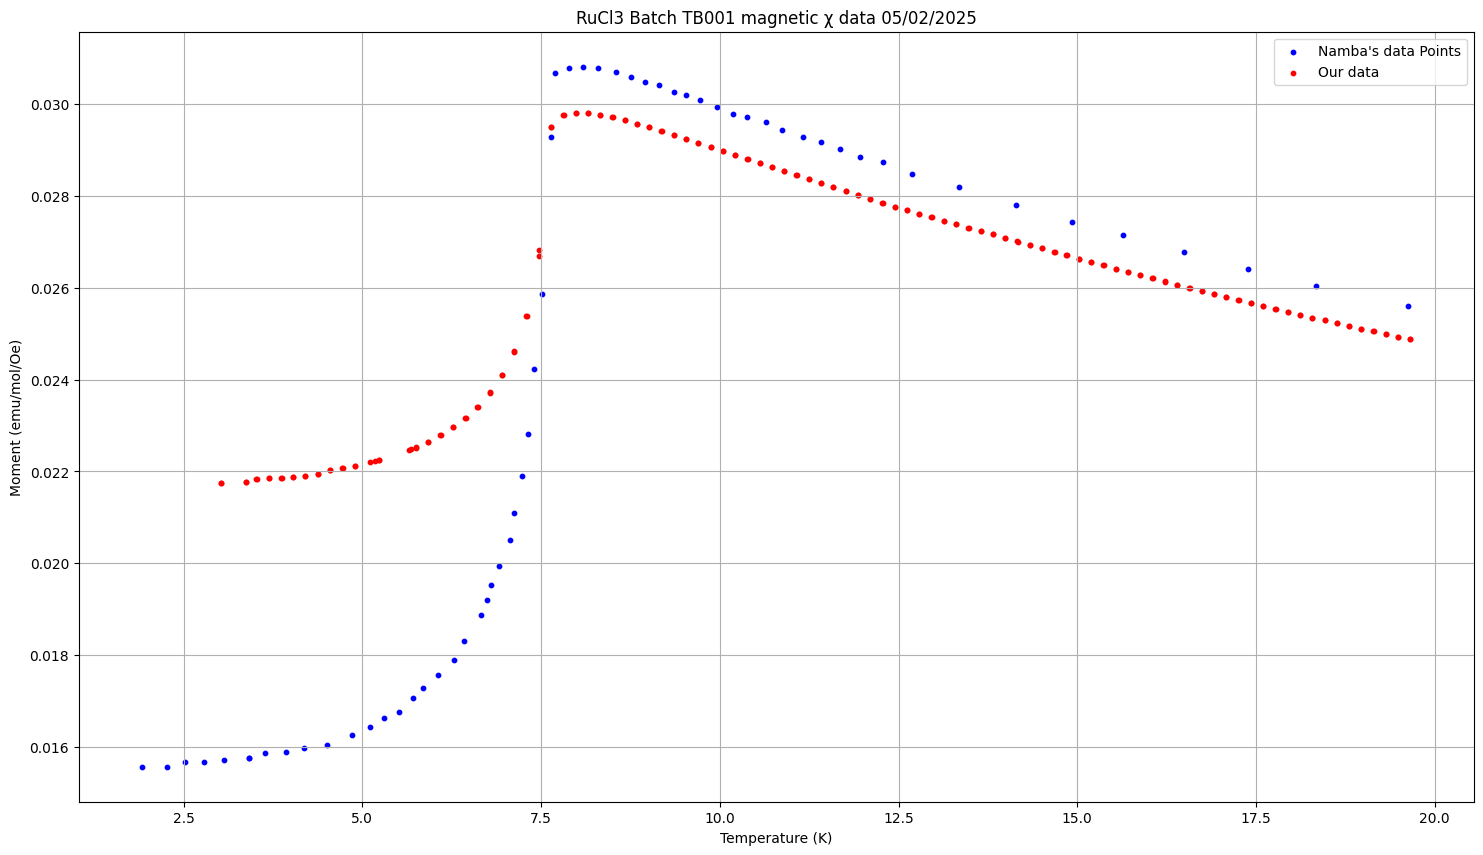

In [53]:
#sample = 'RuCl3'
#plot_mom_vs_temp(df_temperature_range, sample, field, fc_or_zfc)


#Namba paperData
df_ref = pd.read_csv("C:/Users/TXB909/Documents/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/Namba_raw_data.csv", sep=",", encoding='unicode_escape')
x = df_ref.loc[:,'x']
y = df_ref.loc[:,' y']
#namba paper data is in emu/mol so to convert ours we must multiply our data by a conversion factor to get the units as emu/mol
x1 = x
y1 = y

#our data
sample_mass=0.033 #in g
molar_mass = 207.43 #in g/mol
field = 1000 #in oe
conversion_factor = molar_mass/(field*sample_mass)
print(conversion_factor)
x2 = df_temperature_range.loc[:,'Temperature (K)']
y2 = df_temperature_range.loc[:,'Moment (emu)']

x2 = x2
y2 = y2*conversion_factor

fig = figure(figsize=(18,10))

plt.scatter(x1, y1, s=10, 
                #c='r', 
                facecolors='b', edgecolors= 'b', label = 'Namba\'s data Points')
plt.scatter(x2, y2, s=10, 
                #c='r', 
                facecolors='r', edgecolors= 'r', label = 'Our data')
    #plt.plot(x, y, c='r', linewidth=0.8)
plt.title('RuCl3 Batch TB001 magnetic χ data 05/02/2025')
plt.xlabel('Temperature (K)')
plt.ylabel('Moment (emu/mol/Oe)')
plt.grid('both')
plt.legend()
plt.show()

Heat Capacity Plotting


In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as scop
import csv
import matplotlib as mpl
import seaborn as sns
#import Stoner

#THIS BLOCK Sanitises THE DATA AND CONVERTS IT FROM CGS TO SI UNITS IF REQUIRED 


#Filepath where the point the test datafile exists in so it can be accessed
filepath = "C:/Users/TXB909/Documents/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/"
file = "RuCl3_TB001_HeatCapacity_1.csv"

FILEANDPATH=filepath+file

#print(FILEANDPATH)

#N.B. Heat capacity uses 'Time Stamp (Seconds)' which is different to regular PPMS data files
Labels = ['Time Stamp (Seconds)', 'Temperature (K)', 'Magnetic Field (Oe)', 'Moment (emu)', 'Chamber Temp (K)', 'Average Temp (K)', 'Samp HC (J/mole-K)'  ]
#print(FILEANDPATH)


#The filetypes from a PPMS cryostat have a huge amount of non delimeted information at the start, this throws an error when 
#accessed using the csv pandas function so this try and except loop finds the headers as they are in csv format 
#index_of_headers = 0
for i in range(100):
    try:
        df_raw_data = pd.read_csv(FILEANDPATH, sep=",", skiprows=i, encoding='unicode_escape')
        print("headers start on line", i,)
        #make a note of when headers start, need to +1 as we will skip this many rows later and the first one that works is 
        # found not to format the columns correctly
        index_of_headers = int(i+1)
        break
    except:
        None
        #print("headers don't start on line", i,)
    
#print(index_of_headers)

#new dataframe using the index for headers we found
df_raw_data = pd.read_csv(FILEANDPATH, sep=",", skiprows= index_of_headers, encoding='unicode_escape')


#drop any rows containing all NaN's as these are not useful, we use 'all' not 'any' as most columns have at least 1 NaN
df_sanitised_once_data = df_raw_data.dropna(axis = 1, how = 'all', inplace = False)

''' can sanitise again to make and NaN values the previous using .ffill, can make the graph pretty ugly and wrong, but it does make the lines join up, if you care'''
#df_sanitised_once_data = df_raw_data.ffill()


'''need to have a part here that gets the time stamp column and sets it to 0 each time!'''

#Take information such as if data should be left as cgs or converted to si or if the sample was field cooled or zero field cooled for 
#plotting titles of the graphs
fc_or_zfc = 'zfc'
fc_or_zfc = fc_or_zfc.upper()
cgs_or_si = 'cgs'
field = '0.1T'

# Display the filtered dataframe


#start_time = df_sanitised_once_data.loc[0,'Time Stamp (Seconds)']
#print(start_time)
#print(df_sanitised_once_data['Time Stamp (sec)'])
#df_sanitised_once_data = df_sanitised_once_data['Time Stamp (sec)']-29491894

if cgs_or_si.lower() == "cgs":
    print("CGS, units accepted")
    df_sanitised_cgs =df_sanitised_once_data.copy()
    df_name = df_sanitised_cgs
elif cgs_or_si.lower() == "si":
    print("SI, units accepted")
    
    #create a new df containing the sanitised data in correct units
    df_sanitised_si =df_sanitised_once_data.copy()
    df_sanitised_si['Magnetic Field (Oe)']=df_sanitised_si['Magnetic Field (Oe)']*0.0001
    df_sanitised_si['Moment (emu)']=df_sanitised_si['Moment (emu)']*10**(-3)

    '''More variables can be placed here and then renamed below if used, so far only M-field and Moment have been plotted by me'''

    #rename column names to reflect the new units
    df_sanitised_si.rename(columns ={"Magnetic Field (Oe)": "Magnetic Field (T)", "Moment (emu)":"Moment (Am^2)"}, inplace = True)
    df_name = df_sanitised_si
else: 
    print("Invalid Input. Try again")

print(f"Remaining Column Headers are: {df_name.columns}")

#The below is to put limits on the plots for temperature, comment out if you want the full plot
lower_temp = 0
higher_temp = 20
#df_temperature_range = df_name[(df_name['Temperature (K)'] >= lower_temp) & (df_name['Temperature (K)'] <= higher_temp)]


#print(f"{df_raw_data.columns}")

#df_name


headers start on line 14
CGS, units accepted
Remaining Column Headers are: Index(['Time Stamp (Seconds)', 'Comment ()', 'System Status (Code)',
       'System Temp (Kelvin)', 'Field (Oersted)', 'Pressure (Torr)',
       'Sample Temp (Kelvin)', 'Temp Rise (Kelvin)', 'Samp HC (J/mole-K)',
       'Samp HC Err (J/mole-K)', 'Addenda HC (ï¿½J/K)',
       'Addenda HC Err (ï¿½J/K)', 'Total HC (ï¿½J/K)', 'Total HC Err (ï¿½J/K)',
       'Fit Deviation (ChiSquare)', 'Time Const tau1 (seconds)',
       'Time Const tau2 (seconds)', 'Sample Coupling (Percent)',
       'Debye Temp (Kelvin)', 'Debye Temp Err (Kelvin)',
       'Cal Correction (Factor)', 'Wire Cond (W/K)', 'Meas Time (seconds)',
       'Temp Squared (K^2)', 'Samp HC/Temp (J/mole-K/K)',
       'Addenda Offset HC (ï¿½J/K)'],
      dtype='object')


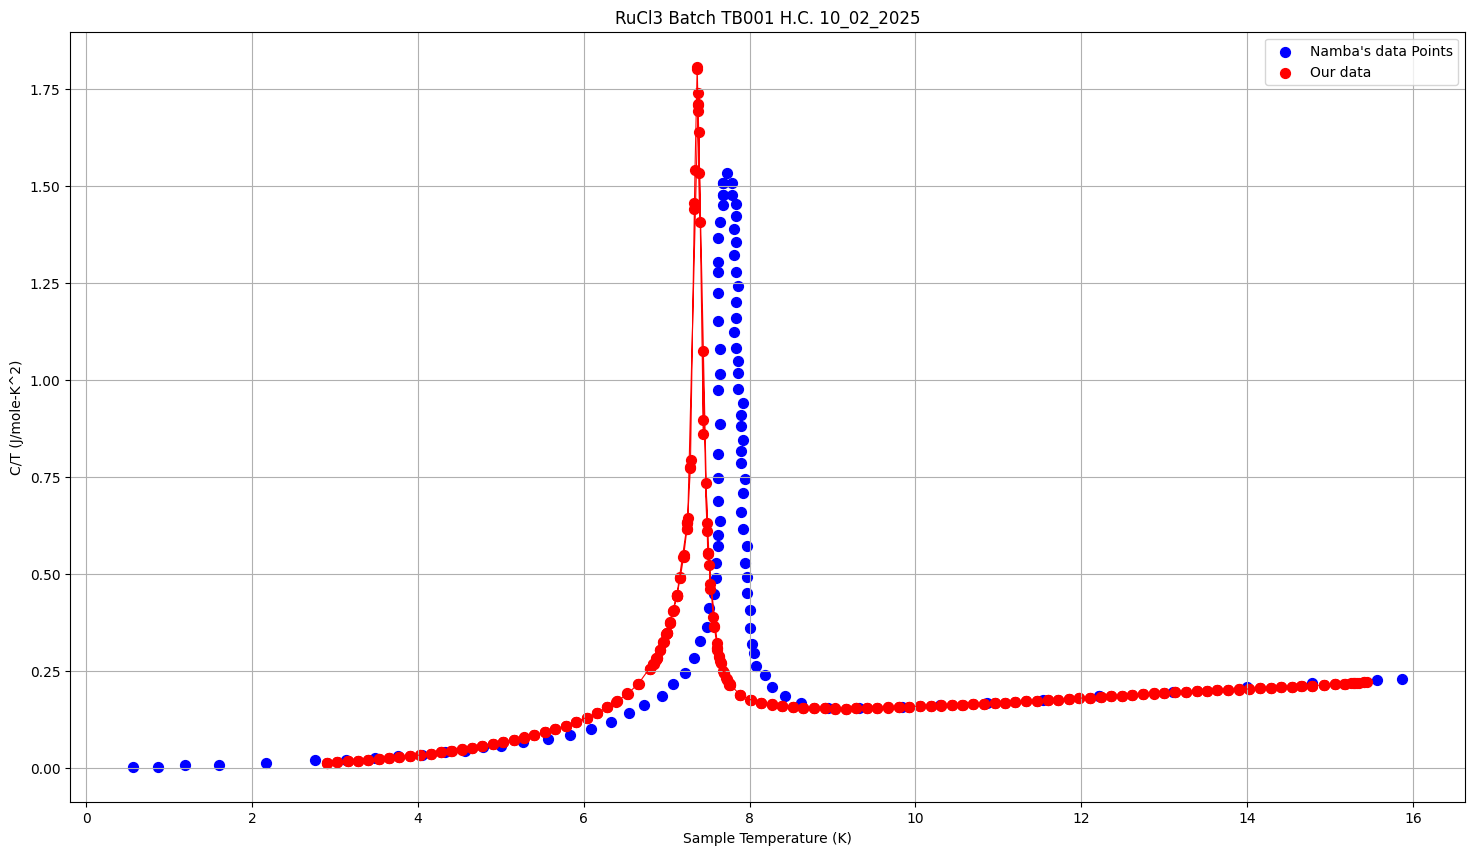

In [57]:
'Samp HC (J/mole-K)'

#Namba paperData
df_ref = pd.read_csv("C:/Users/TXB909/Documents/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/Namba_data_HC.csv", sep=",", encoding='unicode_escape')
x = df_ref.loc[:,'x']
y = df_ref.loc[:,' y']

x1 = x
y1 = y

#our data

sample_mass=0.033 #in g
molar_mass = 207.43 #in g/mol



x2 = df_name.loc[:,'Sample Temp (Kelvin)']
y2 = df_name.loc[:,'Samp HC (J/mole-K)']

#get Specific heat capacity = C/T
y2 = y2/x2

x2 = x2
y2 = y2

fig = figure(figsize=(18,10))

plt.scatter(x1, y1, s=50, 
                #c='r', 
                facecolors='b', edgecolors= 'b', label = 'Namba\'s data Points')
                


plt.scatter(x2, y2, s=50, 
                #c='r', 
                facecolors='r', edgecolors= 'r', label = 'Our data')
plt.plot(x2, y2, c='r', linewidth=0.8)
plt.title('RuCl3 Batch TB001 H.C. 10_02_2025')
plt.xlabel('Sample Temperature (K)')
plt.ylabel('C/T (J/mole-K^2)')
plt.grid('both')
plt.legend()
plt.show()